## 1. 梯度下降过程

### 1.1 二维平面内的梯度下降

In [1]:
# 导入必要的库
import torch
import matplotlib.pyplot as plt

In [2]:
# 定义函数
def f(x):
    return x ** 2 + 4 * x + 1

# 定义初始值
x = torch.tensor(-10., requires_grad=True)

# 迭代更新参数
learning_rate = 0.9

# 用于记录每一步梯度下降的值
xs = []
ys = []

In [3]:
# 开始迭代
for i in range(100):
    # 计算预测值和损失
    y = f(x)

    # 记录参数和损失
    xs.append(x.item())
    ys.append(y.item())

    # 反向传播求梯度
    y.backward()

    # 更新参数
    with torch.no_grad():
        x -= learning_rate * x.grad

        # 梯度清零
        x.grad.zero_()
        
# 打印结果
print(f'最终参数值：{x.item()}')

最终参数值：-2.000000238418579


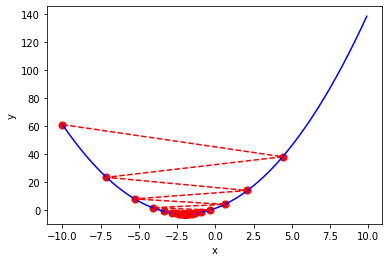

In [4]:
# 显示真实的函数曲线
x_origin = torch.arange(-10, 10, 0.1)
y_origin = f(x_origin)
plt.plot(x_origin, y_origin,'b-')

# 绘制搜索过程
plt.plot(xs,ys,'r--')
plt.scatter(xs, ys, s=50, c='r')  # 圆点大小为 50，颜色为红色
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### 1.2 三维平面内的梯度下降

In [5]:
# 定义函数
def f(x, y):
    return x ** 2 + 2* y ** 2

# 定义初始值
x = torch.tensor(-10., requires_grad=True)
y = torch.tensor(-10., requires_grad=True)

# 记录每一步的值
xs = []
ys = []
zs = []

# 迭代更新参数
learning_rate = 0.1

In [6]:
# 开始迭代
for i in range(100):
    # 计算预测值和损失
    z = f(x, y)

    # 记录参数和损失
    xs.append(x.item())
    ys.append(y.item())
    zs.append(z.item())

    # 反向传播
    z.backward()

    # 更新参数
    with torch.no_grad():
        x.data -= learning_rate * x.grad
        y.data -= learning_rate * y.grad

        # 清空梯度
        x.grad.zero_()
        y.grad.zero_()

# 打印结果
print(f'最终参数值：x={x.item()}, y={y.item()}')

最终参数值：x=-2.0370367614930274e-09, y=-6.533180924230175e-22


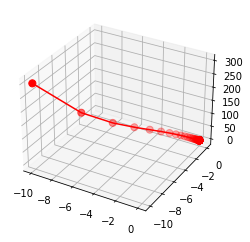

In [7]:
# 绘制图像
ax = plt.figure().add_subplot(projection='3d')
ax.plot(xs, ys, zs, 'r-')
ax.scatter(xs, ys, zs, s=50, c='r')  # 圆点大小为 50，颜色为红色

plt.show()

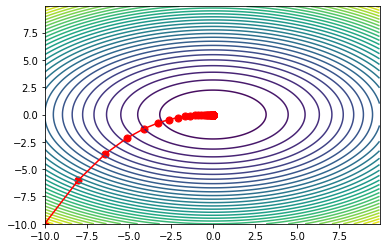

In [8]:
# 绘制原始的二维函数图像
X, Y = torch.meshgrid(torch.arange(-10, 10, 0.1), torch.arange(-10, 10, 0.1), indexing='ij')
Z = f(X, Y)
plt.contour(X, Y, Z, levels=30)

# 绘制搜索过程曲线
plt.plot(xs, ys, 'r-')
plt.scatter(xs, ys, s=50, c='r')  # 圆点大小为 50，颜色为红色
plt.show()

## 2. 不同优化器效果对比

In [9]:
# 导入必要的库
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset  # 用于构造数据加载器
from torch.utils.data import random_split # 用于划分数据集
import torch.optim as optim

In [10]:
# 定义函数
def f(x, y):
    return x ** 2 + 2 * y ** 2

# 定义初始值
num_samples = 1000 # 1000个样本点
X = torch.rand(num_samples) # 均匀分布
Y = torch.rand(num_samples) # 均匀分布
Z = f(X,Y) +  torch.randn(num_samples)  #高斯分布扰动项

dataset = torch.stack([X, Y, Z], dim = 1)
dataset[0]

tensor([0.7447, 0.9030, 2.7870])

In [11]:
# 按照8：2划分数据集
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset=dataset, lengths=[train_size, test_size])

# 将数据封装成数据加载器
train_dataloader = DataLoader(TensorDataset(train_dataset.dataset[:train_size].narrow(1,0,2), train_dataset.dataset[:train_size].narrow(1,2,1)),
                              batch_size=32, shuffle=False)
test_dataloader = DataLoader(TensorDataset(test_dataset.dataset[train_size:].narrow(1,0,2), test_dataset.dataset[train_size:].narrow(1,2,1)),
                             batch_size=32, shuffle=False)

In [12]:
# 定义一个简单模型
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(2, 8)
        self.output = nn.Linear(8, 1)

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        return self.output(x)

In [13]:
# 定义损失函数
loss_fn = nn.MSELoss()

# 初始化模型序列
opt_labels = ['SGD', 'Momentum', 'Adagrad', 'RMSprop', 'Adadelta', 'Adam']
models = [Model(), Model(), Model(), Model(), Model(), Model()] 

# 优化器列表
SGD = optim.SGD(models[0].parameters(), lr=learning_rate)
Momentum = optim.SGD(models[1].parameters(), lr=learning_rate, momentum=0.8, nesterov=True)
Adagrad = optim.Adagrad(models[2].parameters(), lr=learning_rate)
RMSprop = optim.RMSprop(models[3].parameters(), lr=learning_rate)
Adadelta = optim.Adadelta(models[4].parameters(), lr=learning_rate)
Adam = optim.Adam(models[5].parameters(), lr=learning_rate)
opts = [SGD, Momentum, Adagrad, RMSprop, Adadelta, Adam]

# 定义训练和测试误差历史记录数组
train_losses_his = [[],[],[],[],[],[]]
test_losses_his = [[],[],[],[],[],[]]

# 超参数
num_epochs = 50
learning_rate = 0.01 # 学习率

In [14]:
# 模型训练和测试
for epoch in range(num_epochs):
    # 当前epoch每个模型在训练集上的总损失列表
    train_losses = [0,0,0,0,0,0]
    # 遍历训练集
    for inputs, targets in train_dataloader:
        # 迭代不同的模型
        for index, model, optimizer, loss_history in zip(range(6), models, opts, train_losses_his):
            # 预测、损失函数、反向传播
            model.train()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # 记录loss
            train_losses[index] += loss.item()

    
    # 当前epoch每个模型在训测试集上的总损失列表
    test_losses = [0,0,0,0,0,0]
    # 在测试数据上评估，测试模型不计算梯度
    with torch.no_grad():
        # 遍历测试集
        for inputs, targets in test_dataloader:
            # 迭代不同的模型
            for index, model, optimizer, loss_history in zip(range(6), models, opts, test_losses_his):
            # 预测、损失函数、反向传播
                model.eval()
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)
                test_losses[index] += loss.item()
    
    # 计算loss并记录到历史记录中
    for i in range(6):
        train_losses[i] /= len(train_dataloader)
        train_losses_his[i].append(train_losses[i])
        test_losses[i] /= len(test_dataloader)
        test_losses_his[i].append(test_losses[i])

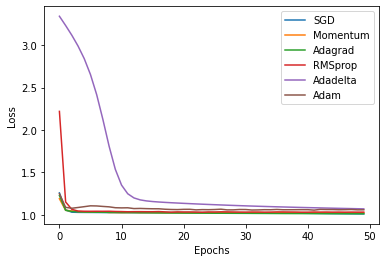

In [15]:
# 绘制训练集损失曲线
for i, l_his in enumerate(train_losses_his):
    plt.plot(l_his, label=opt_labels[i])
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

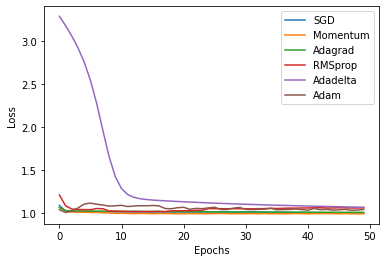

In [16]:
# 绘制测试集损失曲线
for i, l_his in enumerate(test_losses_his):
    plt.plot(l_his, label=opt_labels[i])
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()